In [59]:
import mesa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Agent definitions
Need to decide whether agents wealth is public or private, this will affect expected value of trade and theft calculations

TODO functionalites:
        
        Datacollection
        Taxation
        Probabilistic learning of crime rates - improve it to sliding window, if doesn't work then consider global crime rate to start
        Improve all expected utility calculations

In [81]:
class EconomicAgent(mesa.Agent):
    'money-seeking agent'
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        
        #agent's attributes:
        # self.wealth = (np.random.pareto(2) + 1) * 10
        self.wealth = 10 #mutable
        self.prosperity = 1 #fixed

        self.criminality = 0 #mutable

        self.num_trades_made = 0
        self.num_crimes_witnessed = 0 # how many crimes has this agent seen happen
        self.num_punishments_witnessed = 0 # how many crimes have been punished

        self.has_committed_crime_this_turn = False # only keep true for 1 step of the scheduler, allows cops to arrest
        self.is_arrested = False
        self.time_until_released = 0 # countdown of jail sentence

        self.arrest_aversion = 1 # how painful being in jail is to them

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
    def choose_partner(self):
        # TODO here we can do the logic of choosing a trading partner
        # Possibly also add logic here that calculates the EU of trade/steal for each cellmate and returns best candidate
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 0:
            cellmates = [x for x in cellmates if not x.is_arrested]
            other = self.random.choice(cellmates) # TODO here we can have some wealth prefernces if we want
            return other
        else: return None 
    def make_trade(self, other):
            if other is not None:
                # TODO add some scaling that will make the poorer person benefit less
                other.wealth += (other.wealth + self.wealth)* self.model.prosperity 
                self.wealth += (other.wealth + self.wealth)* self.model.prosperity
                self.num_trades_made +=1
                other.num_trades_made +=1
            
    def steal(self, other):
        theft_value = other.wealth/2
        self.wealth += theft_value
        other.wealth -= theft_value
    def decide_action(self, other):
        '''Decide whether to steal or trade'''
        # TODO calculations of expected value to determine action
        if self.num_crimes_witnessed > 0:
            arrest_chance = self.num_punishments_witnessed/self.num_crimes_witnessed
        else: arrest_chance = 0
        expected_punishment_pain = self.wealth + self.arrest_aversion * self.model.sentence_length
        theft_EU = other.wealth/2 - expected_punishment_pain*arrest_chance
        trade_EU = (other.wealth + self.wealth)* self.model.prosperity
        if trade_EU >= theft_EU:
            return 'trade'
        else:
            return 'steal'
    def vote(self):
        'cast a vote on whether cops are needed'
        #calculate value of the threat of being robbed as product of crime rate and how much you'd have stolen
        # if that value is greater than current tax rate then vote to increase
        if self.num_trades_made >0:
            crime_rate = self.num_crimes_witnessed/self.num_trades_made # TODO fix this
        else: crime_rate = 0
        theft_threat = crime_rate* self.wealth * 0.5 #TODO this is hard coded at .5     
        tax_burden = self.wealth*self.model.tax_rate
        if theft_threat > tax_burden:
            return 1
        else:
            return -1


    def pay_tax(self):
        #wealth tax, could use income tax instead? then the EU calculations are a bit harder
        self.wealth -= self.wealth * self.model.tax_rate
    
    def check_for_crimes(self):
        neighbors = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=True,
            radius=1  # Vision radius
        )
        for neighbor in neighbors:
            if isinstance(neighbor, EconomicAgent) and neighbor.has_committed_crime_this_turn:
                self.num_crimes_witnessed += 1


    def step(self):
        #if they're in jail they don't do anything
        if self.is_arrested:
            self.time_until_released -=1
            if self.time_until_released == 0:
                self.is_arrested = False
        else:
            self.move()
            other = self.choose_partner()
            if self.decide_action(other=other) == 'steal':
                self.steal(other)
            else: self.trade(other)
            self.check_for_crimes()
        self.pay_tax() # or maybe you should only pay tax when you make a trade? idk
        if self.model.steps / self.model.election_frequency == 0:
            vote = self.vote() #returns +/- 1
            self.model.votes += vote

        

In [61]:
class CopAgent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=True)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def look_for_crimes(self):
        neighbors = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=True,
            radius=1  # Vision radius
        )
        for neighbor in neighbors:
            if isinstance(neighbor, EconomicAgent) and neighbor.has_committed_crime_this_turn:
                self.arrest(neighbor)
    def arrest(self, criminal_agent):
        print('arrested agent ' + str(criminal_agent.unique_id))
        criminal_agent.wealth = 1 #TODO
        criminal_agent.is_arrested = True
        criminal_agent.time_until_released = self.model.sentence_length 
        #not sure if this is gonna work right, the idea is that once they're arrested and in jail, ppl are no longer observing the crime being committed
        criminal_agent.has_committed_crime_this_turn = False
        self.model.num_arrests_made += 1
    def step(self):
        self.move()
        self.look_for_crimes()
        

## Model definition

Note about the scheduler: for correct updating of crime statistics, there need to be a few turns, something like

do economic activiy (trade/steal) --> then the cops look around for crimes --> then the agents update their crime stats

which scheduler would this work best with?

I think we need a custom scheduler for the voting mechanism, and then run two schedulers in the model 

In [85]:
class EconomicModel(mesa.Model):
    def __init__(self, num_econ_agents, initial_cops=0, width=10, height=10, election_frequency = 20, sentence_length = 15):
        super().__init__()
        self.num_agents = num_econ_agents
        self.num_cops = initial_cops
        #create scheduler for movement and voting
        self.schedule = mesa.time.RandomActivation(self)
        #space
        self.grid = mesa.space.MultiGrid(width, height, torus = True)

        #parameters
        self.sentence_length = sentence_length
        self.prosperity = 0.05 #global prosperity if we want to model a dynamic economy, use as a multiplier for trade
        self.tax_rate = 0.05 
        self.election_frequency = election_frequency

        #vars
        self.votes = 0
        
        #counters, this will have to be replaced with a datacollector
        self.num_crimes_committed = 0
        self.num_arrests_made = 0
        self.total_stolen = 0
        self.total_trade_income = 0
        self.steps = 0
        
        # create agents
        for i in range(self.num_agents):
            a = EconomicAgent(i, self)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.schedule.add(a)
            self.grid.place_agent(a, (x, y))
        for i in range(self.num_cops):
            c = CopAgent(i, self)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.schedule.add(c)
            self.grid.place_agent(c, (x, y))

    def step(self):
        self.steps += 1
        self.schedule.step()
        if self.steps / self.election_frequency - 1 == 0:        
            if self.votes >0:
                self.tax_rate += 0.01
            else:
                self.tax_rate -= 0.01        
            # Adjusting the number of cops to voting results     
            self.num_cops = self.tax_rate/0.01

            cops = [x for x in self.agents if isinstance(x, CopAgent)]

            if len(cops) < self.num_cops:
                c = CopAgent(i, self)
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)
                self.schedule.add(c)        
                self.grid.place_agent(c, (x, y))
            else:
                cops[0].remove()
                self.schedule.remove(cops[0])


## Running, experiments, visualizations

In [86]:
model = EconomicModel(num_econ_agents=15, initial_cops=0, width=10, height = 10)
model.step()


[Text(0.5, 1.0, 'Number of agents on each cell of the grid')]

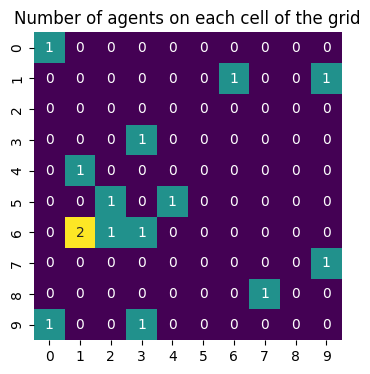

In [87]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
# Plot using seaborn, with a size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(4, 4)
g.set(title="Number of agents on each cell of the grid")